In [105]:
import pandas as pd
from xgboost import XGBRegressor
import sqlite3
from sklearn.metrics import mean_absolute_error

In [106]:
conn = sqlite3.connect('gaokao.db')
cur = conn.cursor()
cur.execute('''
select gk1.year,prov.province,gk1.score,gk1.specialized
from gk1,prov
where gk1.province=prov.province_sx
''')
X = pd.DataFrame(cur.fetchall(), columns=['year', 'province', 'score', 'specialized'])
print(X)

     year  province  score specialized
0    2022       北京市    617          综合
1    2022       天津市    642          综合
2    2022       河北省    611       历史类一批
3    2022       河北省    590       物理类一批
4    2022       山西省    547        文史一批
..    ...       ...    ...         ...
351  2019       青海省    521        理工一批
352  2019   宁夏回族自治区    603        文史一批
353  2019   宁夏回族自治区    555        理工一批
354  2019  新疆维吾尔自治区    586        文史一批
355  2019  新疆维吾尔自治区    568        理工一批

[356 rows x 4 columns]


In [107]:
X_test = X[X['year'] == 2022]
X_train = X[X['year'] != 2022]
print(X_train)
print(X_test)

     year  province  score  specialized
81   2021       北京市    598           综合
82   2021       天津市    637           综合
83   2021       河北省    604        历史类一批
84   2021       河北省    593        物理类一批
85   2021       河北省    589  物理学（中外合作办学）
..    ...       ...    ...          ...
351  2019       青海省    521         理工一批
352  2019   宁夏回族自治区    603         文史一批
353  2019   宁夏回族自治区    555         理工一批
354  2019  新疆维吾尔自治区    586         文史一批
355  2019  新疆维吾尔自治区    568         理工一批

[275 rows x 4 columns]
    year  province  score specialized
0   2022       北京市    617          综合
1   2022       天津市    642          综合
2   2022       河北省    611       历史类一批
3   2022       河北省    590       物理类一批
4   2022       山西省    547        文史一批
..   ...       ...    ...         ...
76  2022   宁夏回族自治区    552        文史一批
77  2022   宁夏回族自治区    513        理工一批
78  2022  新疆维吾尔自治区    534        文史一批
79  2022  新疆维吾尔自治区    516        理工一批
80  2022  新疆维吾尔自治区    479    南疆计划（理工）

[81 rows x 4 columns]


In [108]:
y = X_train['score']
y_test = X_test['score']
X_train = X_train.drop(['score'], axis=1)
X_test = X_test.drop(['score'], axis=1)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0
for col in X_test.columns:
    if col not in X_train.columns:
        X_train[col] = 0
X_test = X_test[X_train.columns]
print(X_train)
print(X_test)
print(y)
print(y_test)

     year  province_上海市  province_云南省  province_内蒙古自治区  province_北京市  \
81   2021             0             0                0             1   
82   2021             0             0                0             0   
83   2021             0             0                0             0   
84   2021             0             0                0             0   
85   2021             0             0                0             0   
..    ...           ...           ...              ...           ...   
351  2019             0             0                0             0   
352  2019             0             0                0             0   
353  2019             0             0                0             0   
354  2019             0             0                0             0   
355  2019             0             0                0             0   

     province_吉林省  province_四川省  province_天津市  province_宁夏回族自治区  province_安徽省  \
81              0             0             0         

In [109]:
model = XGBRegressor(n_estimators=500)
model.fit(X_train, y,eval_set=[(X_test, y_test)], verbose=False)
y_pred = model.predict(X_test)
print(y_pred)
print(mean_absolute_error(y_pred, y_test))

[598.0022  637.00037 603.99756 592.9984  603.99194 579.0093  553.0021
 549.0612  571.00757 546.9387  528.0008  600.0053  571.0047  571.0204
 555.99396 538.9819  547.0048  525.9931  539.00836 579.03094 563.9818
 555.02484 566.9976  531.99756 542.00037 600.00073 589.0005  633.98895
 634.96405 619.0024  623.0203  594.0197  599.99976 612.00006 589.98553
 622.943   613.99713 611.041   595.0187  580.00055 630.93713 610.0119
 626.03485 604.0097  612.03455 591.99646 631.9965  617.0016  614.00146
 605.0013  612.0019  604.99805 606.9984  613.9491  586.0441  665.00226
 620.00354 614.0034  603.0259  625.95636 594.9955  642.9725  575.02856
 643.9612  580.0358  598.9974  433.0004  565.99976 379.00073 610.0056
 572.97125 519.02356 585.01794 557.98926 531.0318  504.95993 588.0001
 486.0125  572.02014 544.99    550.4301 ]
20.623454529562114


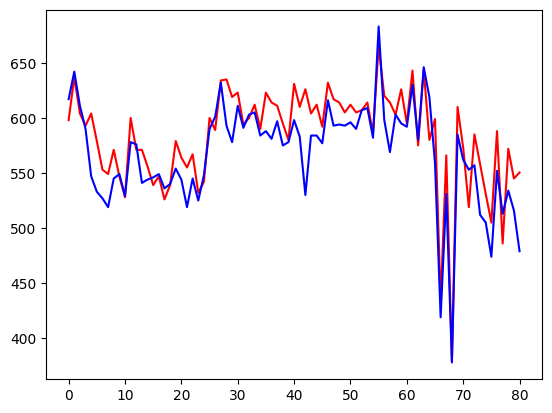

In [110]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(0, 81), y_pred, 'r')
plt.plot(np.arange(0, 81), y_test, 'b')
plt.show()

In [111]:
import pyecharts.options as opts
from pyecharts.charts import Map
def visual(df, year, specialized):
    c = (
        Map()
        .add("高考分数", [list(z) for z in zip(df['province'], df['def'])], "china")
        .set_global_opts(
            title_opts=opts.TitleOpts(title="{}{}高考分数".format(year, specialized)),
            visualmap_opts=opts.VisualMapOpts(max_=100, min_=0),
        )
    )
    c.render('./map.html')


In [112]:
specializeds = cur.execute('''
select specialized
from gk1
where year = 2022
group by specialized
order by count(*) desc
''')
specializeds = [l[0] for l in specializeds]
l1 = [0, 2]
q_specialized = tuple([specializeds[i] for i in l1])

In [113]:
x_visual = X[X['year'] == 2022]
x_visual['def'] = abs(y_pred - x_visual['score'])
x_visual = x_visual[x_visual['specialized'].isin(q_specialized)]

visual(x_visual, 2022, q_specialized)


F:\Program\AI\miniconda\envs\Py_hw\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
